In [1]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm as _tqdm
import gym
import argparse
import copy
from gridworld import GridworldEnv
from tqdm import tqdm
import pickle
import itertools

from contextlib import contextmanager
import sys, os

from DQN_model import QNetwork
from DQN_replay import ReplayMemory
from DQN_policy import EpsilonGreedyPolicy, get_epsilon
from DQN_training import train
from DQN_plots import plot_smooth
from DQN_main import run_episodes

In [2]:
# From https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python
@contextmanager
def suppress_stdout(suppress):
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        if suppress:
            sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [3]:
def plot_with_error(losses, unc=True, filename=None, plot_label="Loss", y_label="Loss", colour='blue',
                    fig_in=None, red_line=None, smooth=None):
    losses = np.array(losses)

    means = np.mean(losses, axis=0)
    errors = np.std(losses, axis=0)
    
    if unc: # Plot uncertainty instead of std
        errors = errors / np.sqrt(losses.shape[0])
    
    
    
    
    if fig_in is None:
        fig, ax = plt.subplots(1)
        if red_line is not None:
            plt.axhline(y=red_line, color='r', linestyle='-')
    else:
        fig, ax = fig_in
        
    if smooth is not None:
        cummeans = np.cumsum(np.insert(means, 0, 0))
        means = (cummeans[smooth:] - cummeans[:-smooth]) / float(smooth)
        
        cumerrors = np.cumsum(np.insert(errors, 0, 0))
        errors = (cumerrors[smooth:] - cumerrors[:-smooth]) / float(smooth)
        
    x = np.arange(len(means))    
    ax.plot(x, means, lw=2, label=f"{plot_label}", color=colour)
    ax.fill_between(x, means+errors, means-errors, facecolor=colour, alpha=0.5)
    if fig_in is None:
        ax.legend(loc='upper left', fancybox=True)
    ax.set_xlabel('Episodes', fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    
    
    ax.grid()
    if fig_in is not None:
        return fig, ax
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')
        
def plot_multiple(multiple_losses, labels, filename=None, y_label="Loss",
                  red_line=None, br=False, legend_off=False, log=False, smooth=None,
                 subplot = None, title="Title"): # Assumes multiple losses contains a set of loss_list's for each parameter
    # File prepends should be a list of names
    colours = ['b', 'g', 'y', 'm', 'c', 'k', 'w']
    if subplot is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = subplot
    if red_line is not None:
        ax.axhline(y=red_line, color='r', linestyle='-')
    for (losses, colour, label) in zip(multiple_losses, colours, labels):
        plot_with_error(losses, unc=True, plot_label=label, y_label=y_label, colour=colour,
                        fig_in = (fig,ax), red_line=red_line, smooth=smooth)
    if log:
        plt.yscale("log")
    ax.grid()
    if br and not legend_off:
        ax.legend(loc='lower right', fancybox=True, framealpha=0.4, fontsize=13)
    elif not legend_off:
        ax.legend(loc='upper left', fancybox=True, framealpha=0.4, fontsize=13)
    ax.set_title(title, fontsize=15)
    if filename is not None:
        save_path = '../plots/'
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
                
        plt.savefig(f"{save_path}/{filename}.pdf", format='pdf')
    
    

In [4]:
def pickle_tuple(tupl, filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'wb') as f:
        pickle.dump(tupl,f)

def unpickle_tuple(filename='test'):
    save_path = '../pickles/'
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    with open(f"{save_path}/{filename}.pkl", 'rb') as f:
        return pickle.load(f)

In [5]:
def run_setting(env_name, num_episodes, batch_size, memory_size, discount_factor, learn_rate, seed, num_hidden, 
                min_eps, max_eps, anneal_time, clone_interval, clipping, suppress_printing):
    # mostly copied from main() in DQN_main.py, removed some code for overview
    # if you want replay to be turned off, use batch_size=memory_size=1
    # returns episode durations (list), losses averaged per step (list), max abs q averaged per step (list)
    
    env = GridworldEnv() if env_name == "GridWorldEnv" else gym.make(env_name)

    obs_shape = env.observation_space.shape
    num_actions = env.action_space.n
    if env_name == "Blackjack-v0":
        obs_size = 3
    elif len(obs_shape) > 0: 
        obs_size = obs_shape[0]
    else:
        obs_size = 1
#     obs_size = obs_shape[0] if len(obs_shape) > 0 else 1

    memory = ReplayMemory(memory_size)

    # for reproducibility
    random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    Q_net = QNetwork(obs_size, num_actions, num_hidden=num_hidden)
    policy = EpsilonGreedyPolicy(Q_net, num_actions)
    with suppress_stdout(suppress_printing):
        return run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, 
                            learn_rate, clone_interval, min_eps, max_eps, anneal_time, clipping)

In [ ]:
# Replay ON, Target Network OFF
settings = {
    'env_name':"CartPole-v1",
    'num_episodes':1000,
    'batch_size':64, 
    'memory_size':50000, 
    'discount_factor':0.8, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    durations_list_rT_tF.append(durations)
    losses_list_rT_tF.append(losses)
    max_Qs_list_rT_tF.append(max_Qs)
filename = f"CartPole-v1_{seed}_replay_on"
pickle_tuple((durations_list_rT_tF, losses_list_rT_tF, max_Qs_list_rT_tF, settings), filename=filename)

In [70]:
# ACROBOT: Replay OFF, Target Network OFF
settings = {
    'env_name':"Acrobot-v1",
    'num_episodes':600,
    'batch_size':1, 
    'memory_size':1, 
    'discount_factor':0.999, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

Bj_durations_list_rF_tF, Bj_losses_list_rF_tF, Bj_max_Qs_list_rF_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    Bj_durations_list_rF_tF.append(durations)
    Bj_losses_list_rF_tF.append(losses)
    Bj_max_Qs_list_rF_tF.append(max_Qs)
filename = f"Imp2-Acrobot-v1_replay_off_tn_off"
pickle_tuple((Bj_durations_list_rF_tF, Bj_losses_list_rF_tF, Bj_max_Qs_list_rF_tF, settings), filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]/home/daniel/anaconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/mnt/20E2A17CE2A15736/Users/Public/Documents/Central Documents/Education/MSc AI UvA/Courses/Reinforcement Learning/Labs/DQN-Experiments/scripts/DQN_model.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)  # Seems like this does nothing, even when numpy gets passed into Q


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [04:22<39:23, 262.59s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [07:43<32:32, 244.05s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [11:27<27:47, 238.19s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [14:51<22:46, 227.72s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [18:25<18:37, 223.57s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [22:28<15:18, 229.55s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [26:17<11:28, 229.43s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [30:00<07:34, 227.32s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [34:50<04:06, 246.30s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [38:59<00:00, 233.95s/it]


In [71]:
# ACROBOT: Replay ON, Target Network OFF
settings = {
    'env_name':"Acrobot-v1",
    'num_episodes':600,
    'batch_size':64, 
    'memory_size':10000, 
    'discount_factor':0.999, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':None, 
    'clipping':True,
    'suppress_printing':True
}

Bj_durations_list_rT_tF, Bj_losses_list_rT_tF, Bj_max_Qs_list_rT_tF = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    Bj_durations_list_rT_tF.append(durations)
    Bj_losses_list_rT_tF.append(losses)
    Bj_max_Qs_list_rT_tF.append(max_Qs)
filename = f"Imp2-Acrobot-v1_replay_on_tn_off"
pickle_tuple((Bj_durations_list_rT_tF, Bj_losses_list_rT_tF, Bj_max_Qs_list_rT_tF, settings), filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [02:39<23:56, 159.59s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [05:04<20:41, 155.25s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [07:29<17:44, 152.07s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [10:16<15:39, 156.54s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [12:30<12:28, 149.78s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [14:41<09:36, 144.19s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [16:54<07:02, 140.83s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [19:24<04:47, 143.52s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [21:44<02:22, 142.44s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [24:10<00:00, 145.01s/it]


In [72]:
# ACROBOT: Replay OFF, Target Network ON
settings = {
    'env_name':"Acrobot-v1",
    'num_episodes':600,
    'batch_size':1, 
    'memory_size':1, 
    'discount_factor':0.999, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':50000, 
    'clipping':True,
    'suppress_printing':True
}

Bj_durations_list_rF_tT, Bj_losses_list_rF_tT, Bj_max_Qs_list_rF_tT = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    Bj_durations_list_rF_tT.append(durations)
    Bj_losses_list_rF_tT.append(losses)
    Bj_max_Qs_list_rF_tT.append(max_Qs)
filename = f"Imp2-Acrobot-v1_replay_off_tn_on"
pickle_tuple((Bj_durations_list_rF_tT, Bj_losses_list_rF_tT, Bj_max_Qs_list_rF_tT, settings), filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [03:23<30:34, 203.86s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [08:49<32:03, 240.46s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [13:55<30:19, 259.97s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [18:39<26:43, 267.20s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [23:44<23:13, 278.70s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [28:52<19:09, 287.26s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [31:58<12:50, 256.98s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [36:59<09:00, 270.15s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [40:40<04:15, 255.61s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [42:40<00:00, 256.01s/it]


In [73]:
# ACROBOT: Replay ON, Target Network ON
settings = {
    'env_name':"Acrobot-v1",
    'num_episodes':600,
    'batch_size':64, 
    'memory_size':10000, 
    'discount_factor':0.999, 
    'learn_rate':1e-3, 
    'num_hidden':128, 
    'min_eps':0.05, 
    'max_eps':1., 
    'anneal_time':1000, 
    'clone_interval':500, 
    'clipping':True,
    'suppress_printing':True
}

Bj_durations_list_rT_tT, Bj_losses_list_rT_tT, Bj_max_Qs_list_rT_tT = [], [], []
for seed in tqdm(range(1,11)):
    durations, losses, max_Qs = run_setting(**settings, seed=seed)
    Bj_durations_list_rT_tT.append(durations)
    Bj_losses_list_rT_tT.append(losses)
    Bj_max_Qs_list_rT_tT.append(max_Qs)
filename = f"Imp3-Acrobot-v1_replay_on_tn_on"
pickle_tuple((Bj_durations_list_rT_tT, Bj_losses_list_rT_tT, Bj_max_Qs_list_rT_tT, settings), filename=filename)

  0%|          | 0/10 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 10%|█         | 1/10 [01:33<13:57, 93.10s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 20%|██        | 2/10 [02:59<12:07, 91.00s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 30%|███       | 3/10 [04:24<10:24, 89.14s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 40%|████      | 4/10 [05:57<09:01, 90.32s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 50%|█████     | 5/10 [07:39<07:49, 93.95s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 60%|██████    | 6/10 [09:23<06:28, 97.09s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 70%|███████   | 7/10 [10:58<04:48, 96.27s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 80%|████████  | 8/10 [12:28<03:08, 94.49s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


 90%|█████████ | 9/10 [13:59<01:33, 93.39s/it]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


100%|██████████| 10/10 [15:29<00:00, 92.93s/it]


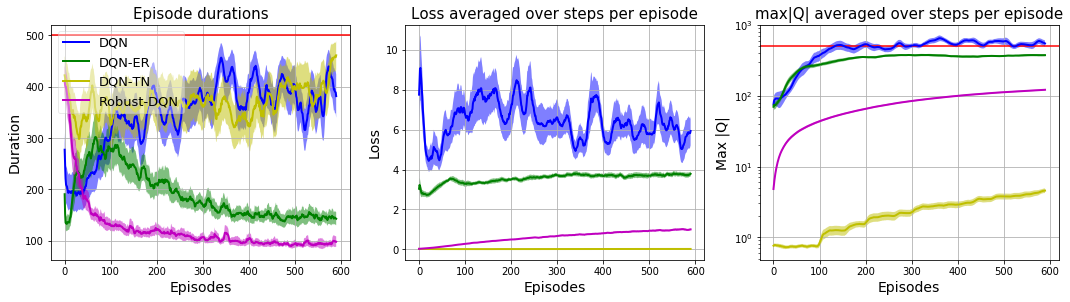

In [10]:
filename = f"Imp2-Acrobot-v1_replay_off_tn_off"
(Bj_durations_list_rF_tF, Bj_losses_list_rF_tF, Bj_max_Qs_list_rF_tF, settings) = \
unpickle_tuple(filename=filename)

filename = f"Imp2-Acrobot-v1_replay_on_tn_off"
(Bj_durations_list_rT_tF, Bj_losses_list_rT_tF, Bj_max_Qs_list_rT_tF, settings) = \
unpickle_tuple(filename=filename)

filename = f"Imp2-Acrobot-v1_replay_off_tn_on"
(Bj_durations_list_rF_tT, Bj_losses_list_rF_tT, Bj_max_Qs_list_rF_tT, settings) = \
unpickle_tuple(filename=filename)

filename = f"Imp3-Acrobot-v1_replay_on_tn_on"
(Bj_durations_list_rT_tT, Bj_losses_list_rT_tT, Bj_max_Qs_list_rT_tT, settings) = \
unpickle_tuple(filename=filename)


# Using subplots:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4.3), tight_layout=True)
plot_multiple([Bj_losses_list_rF_tF, Bj_losses_list_rT_tF, Bj_losses_list_rF_tT, Bj_losses_list_rT_tT], 
              labels=["DQN", "DQN-ER",
                     "DQN-TN", "Robust-DQN"],  
              legend_off = True, log=True, smooth = 10,
             subplot=(fig,ax2), title="Loss averaged over steps per episode")

discount_factor = settings['discount_factor']
line_level = 1./(1-discount_factor)

plot_multiple([Bj_max_Qs_list_rF_tF, Bj_max_Qs_list_rT_tF, Bj_max_Qs_list_rF_tT, Bj_max_Qs_list_rT_tT], 
              labels=["DQN", "DQN-ER",
                     "DQN-TN", "Robust-DQN"],  
              y_label='Max |Q|', red_line=500, 
              legend_off = True, smooth=10, subplot=(fig,ax3), title="max|Q| averaged over steps per episode")

plot_multiple([Bj_durations_list_rF_tF, Bj_durations_list_rT_tF, Bj_durations_list_rF_tT, Bj_durations_list_rT_tT], 
              labels=["DQN", "DQN-ER",
                     "DQN-TN", "Robust-DQN"],  
              filename="Acrobot_sub", y_label='Duration', red_line=500, br=False, 
              legend_off = False, smooth=10, subplot=(fig,ax1), title="Episode durations")